# Models and Evaluation

In [72]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('../assets/final/data.csv')
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(328, 10)
(354, 10)


In [73]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [74]:
def split_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [75]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = split_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (328, 8)

Test data shape:  (354, 8)

Train shape: (328, 1)

Test shape: (354, 1)


### Resampling

In [76]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [77]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)



Train data shape:  (564, 8)

Train shape: (564, 1)


### Algorithms

In [78]:
def add_model(name, model, use_smote=False):
    import datetime
    X_train = _X_train.copy()
    X_test = _X_test.copy()
    smote_X_train = _smote_X_train.copy()

    start = datetime.datetime.now()
    if use_smote: model.fit(smote_X_train, np.ravel(_smote_y_train.values))
    else: model.fit(X_train, np.ravel(_y_train.values))
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': np.ravel(_y_train.values), 
                    'y_test': np.ravel(_y_test.values),
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [79]:
SMOTE = True

In [80]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=SMOTE
)

In [81]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=SMOTE
)

In [82]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=SMOTE
)

In [83]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=SMOTE
)

In [84]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=SMOTE
)

In [90]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=SMOTE
)

## Prediction

In [91]:
def predict(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    pred = result['model'].predict(result['X_'+prefix])
    result[prefix+'pred'] = pred

for name in results.keys():
    predict(name)
for name in results.keys():
    predict(name, isTrain=True)

In [92]:
def predict_proba(name, isTrain=False):
    prefix = 'train' if isTrain else 'test'
    result = results[name]
    proba = result['model'].predict_proba(result['X_'+prefix])
    result[prefix+'pred_prob'] = proba

for name in results.keys():
    predict_proba(name)
for name in results.keys():
    predict_proba(name, isTrain=True)


       Id  loan_id  Predicted  status
0    5895     5895       0.05       0
1    7122     7122       0.97       1
2    6173     6173       0.42       0
3    6142     6142       0.02       0
4    5358     5358       0.40       0
..    ...      ...        ...     ...
349  4989     4989       0.79       0
350  5221     5221       0.23       0
351  6402     6402       0.12       0
352  5346     5346       0.57       0
353  6748     6748       0.50       0

[354 rows x 4 columns]


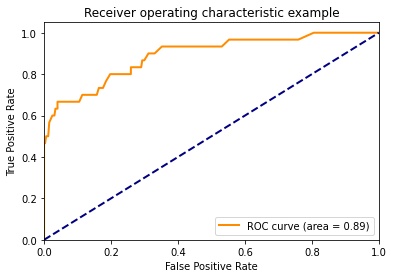

'\ndef roc_and_auc(name, isTrain=False):\n    fig, ax = plt.subplots()\n    result = results[name]\n    fpr, tpr, thresholds = roc_curve(result[\'mix\'][\'status\'], result[\'mix\'][\'Predicted\'], pos_label=result[\'model\'].classes_[0])\n    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax,name=(name.upper()))\n    print(name.upper(), \'test\' + ":\t", auc(fpr, tpr))\n\n#for name in results.keys():\n#    roc_and_auc(name)\nroc_and_auc(\'rf\')\n'

In [93]:
expected = pd.read_csv('../assets/expected.csv')
expected['status'] = expected['status'].map(lambda x: 0 if x == 1 else 1)


'''
for name in results.keys():
    d = {'Id': ids_test.values, 'Predicted': results[name]['testpred_prob'][:,0]}
    df = pd.DataFrame(data=d)
    mix = pd.merge(df, expected, left_on='Id', right_on='loan_id', how='left')
    print(mix[['Id', 'loan_id', 'Predicted', 'status']])
    #results[name]['mix'] = mix[['Id', 'loan_id', 'Predicted', 'status']]
'''
d = {'Id': ids_test.values, 'Predicted': results['rf']['testpred_prob'][:,0]}
df = pd.DataFrame(data=d)
mix = pd.merge(df, expected, left_on='Id', right_on='loan_id', how='left')
print(mix[['Id', 'loan_id', 'Predicted', 'status']])

# Calculate the Roc and AUC of the model using Predicted and Status columns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(mix['status'], mix['Predicted'])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

'''
def roc_and_auc(name, isTrain=False):
    fig, ax = plt.subplots()
    result = results[name]
    fpr, tpr, thresholds = roc_curve(result['mix']['status'], result['mix']['Predicted'], pos_label=result['model'].classes_[0])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax,name=(name.upper()))
    print(name.upper(), 'test' + ":\t", auc(fpr, tpr))

#for name in results.keys():
#    roc_and_auc(name)
roc_and_auc('rf')
'''

